Generating easily distinguishable test figures to experiment with changing 'time' in unity i.e. loading different views of the earth over time

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
import geopandas as gpd
from cartopy.io import shapereader
import glob

In [4]:
files = glob.glob("Data/*")  # all files/folders
f_name = 'Data/' + 'ESACCI-GHG-L2-CH4-CO-TROPOMI-WFMD-20240301-fv3.nc'
ds = xr.open_dataset(f_name)

In [5]:
# Extract variables
xch4 = ds["xch4"]
lat = ds["latitude"]
lon = ds["longitude"]

# Optional: Mask invalid or fill values (e.g., where xch4 <= 0 or NaN)
valid = xch4.where((xch4 > 0) & (~xch4.isnull()), drop=True)
c_valid = valid
lat = lat.where(valid.notnull(), drop=True)
lon = lon.where(valid.notnull(), drop=True)

In [10]:
# ========== USER-DEFINED COLOURS ==========
SEA_COLOR = "darkblue"     # Change sea color here
SEA_COLOR = "purple" 
# SEA_COLOR = (0, 0, 139/255, 0.75)  # darkblue with 75% opacity

LAND_COLOR = "palegreen"        # Change land color here
LAND_COLOR = "green" 
# LAND_COLOR = (0, 1.0, 0, 0.4)  # RGB for green + alpha

BORDER_COLOR = "black"      # Country border color
COASTLINE_COLOR = "black"   # Coastline color
# ==========================================

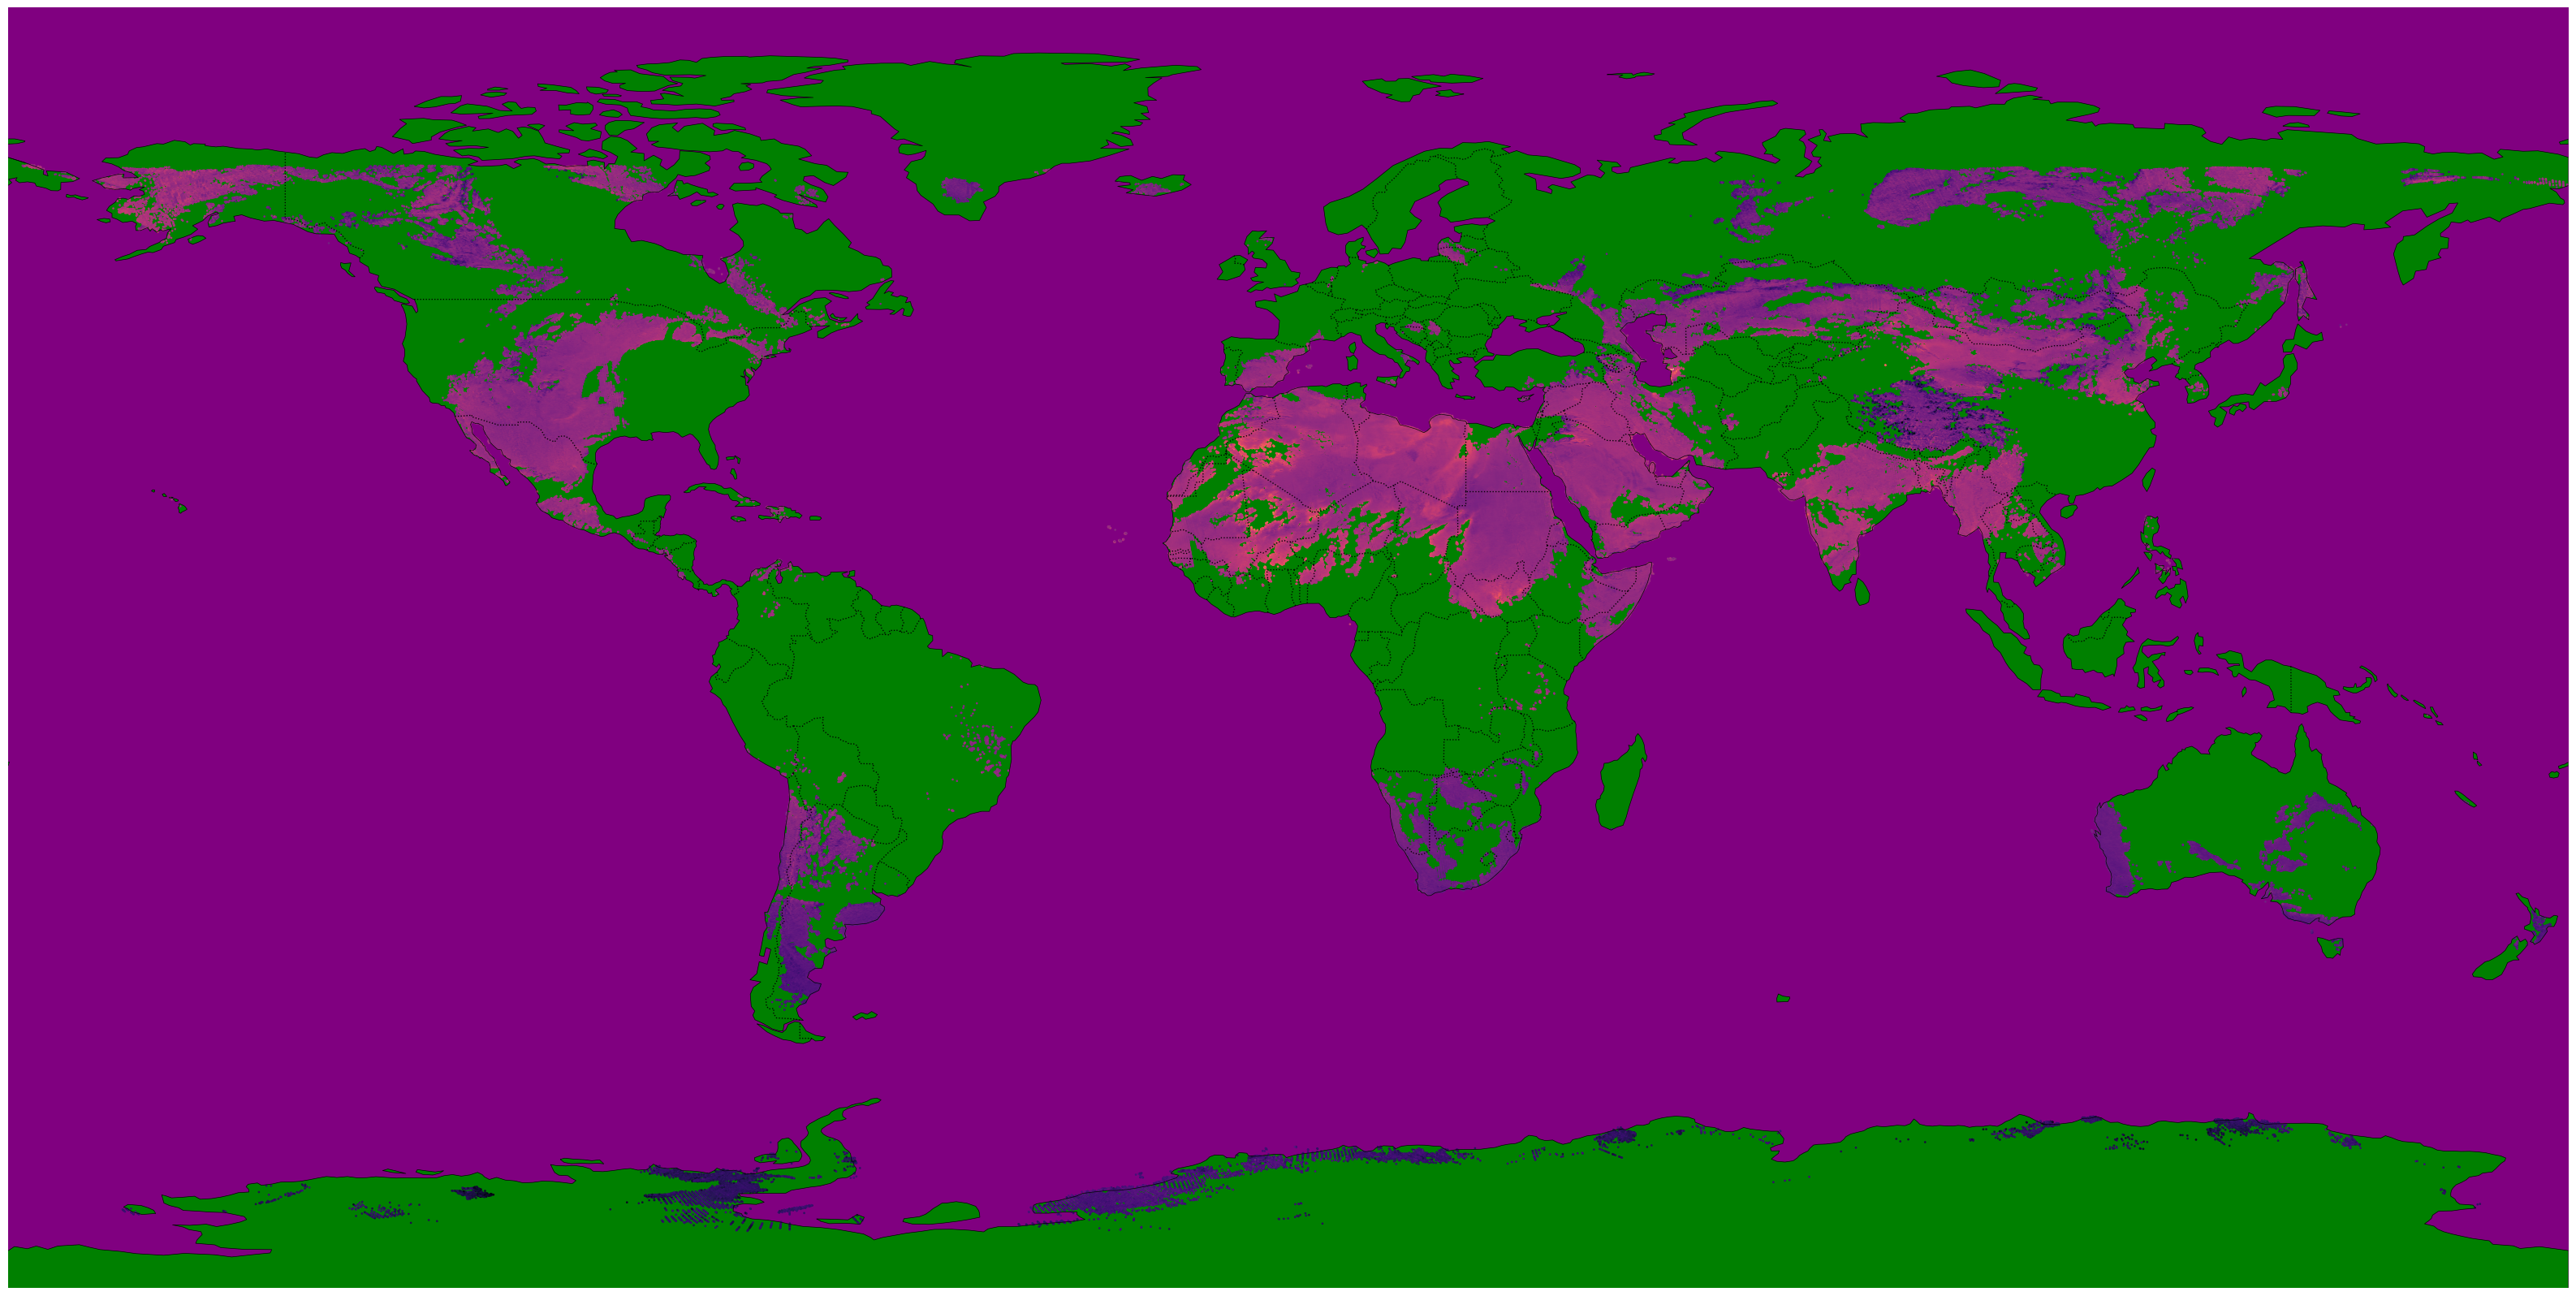

In [11]:
# Colours defined above
# ==========================================

# Example inputs (replace these with your TROPOMI data arrays)
# lon, lat, c_valid = ...

# Set DPI and figure size
dpi = 96
width_in = 4096 / dpi
height_in = 2048 / dpi

fig = plt.figure(figsize=(width_in, height_in), dpi=dpi)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.set_facecolor(SEA_COLOR)  # Sea background color

# Add land as a white shape layer
ax.add_feature(cfeature.LAND.with_scale('110m'), facecolor=LAND_COLOR, edgecolor='none')

# Load land polygons for masking
land = gpd.read_file("shapefiles/ne_10m_admin_0_countries.shp")  # Adjust path if needed

# Convert lon/lat to Point geometries
points = gpd.GeoSeries([Point(xy) for xy in zip(lon, lat)], crs="EPSG:4326")

# Keep only land points
land_points = gpd.sjoin(gpd.GeoDataFrame(geometry=points), land, how="inner", predicate="within")

# Extract only land values
valid_indices = land_points.index
lon_land = np.array(lon)[valid_indices]
lat_land = np.array(lat)[valid_indices]
c_valid_land = np.array(c_valid)[valid_indices]

# Scatter plot for land-only data
sc = ax.scatter(
    lon_land, lat_land, c=c_valid_land, s=1,
    cmap="magma", transform=ccrs.PlateCarree()
)

# Add borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor=BORDER_COLOR)
ax.coastlines(color=COASTLINE_COLOR, linewidth=0.5)

# Remove ticks and frame
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

# Save the figure
plt.savefig("Test_Figures_time/Figure_3.png", dpi=dpi, bbox_inches='tight', pad_inches=0)
plt.show()